# Import Library

In [1]:
# Data Loading
import xarray as xr  

# Data Processing
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap

# Ignore warning messages
import warnings
warnings.filterwarnings(action='ignore')

# Data Load

In [2]:
# http://research.jisao.washington.edu/data_sets/ndvi/
path_ndvi = './ndviavhrr19812001.nc'

# https://psl.noaa.gov/data/gridded/data.gpcp.html (precipitation)
path_precip = './precip.mon.mean.nc'

ndvi_data   = xr.open_dataset(path_ndvi)
precip_data = xr.open_dataset(path_precip)

print(ndvi_data) # print dataset infomation 
print(precip_data) # print dataset infomation 

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 252)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2001-12-01
Data variables:
    data     (time, lat, lon) float32 ...
Attributes:
    history:     \nNational Aeronautics and Space Administration advanced ver...
    title:       NASA AVHRR normalized difference vegetation index, 1981-2001
    convention:  The file is written in COARDS-compliant netCDF:\nftp://ftp.u...
<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 496)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-04-01
Dimensions without coordinates: nv
Data variables:
    time_bnds 

# Data Processing

In [3]:
# select variable
ndvi = ndvi_data.data_vars['data']
precip = precip_data.data_vars['precip']

print(ndvi.shape)  # [time, lat, lon]
print(precip.shape)

(252, 180, 360)
(496, 72, 144)


In [4]:
# Convert longitude coordinates from 0-359 to -180-179:
# http://xarray.pydata.org/en/stable/generated/xarray.Dataset.assign_coords.html

ndvi_ = ndvi.assign_coords({"lon": (((ndvi.lon + 180) % 360) - 180)})
ndvi_ = ndvi_.sortby('lon')

precip_ = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 180)})
precip_ = precip_.sortby('lon')

In [5]:
# Sahel area average
# check order of coordination (lon, lat)
vsahel = ndvi_.sel(lon=slice(-10,30), lat=slice(15,10)).mean(dim=['lon', 'lat'])
psahel = precip_.sel(lon=slice(-10,30), lat=slice(10,15)).mean(dim=['lon', 'lat'])

In [6]:
# Select North Africa
p_North_Africa = precip_.sel(lon=slice(-25,65), lat=slice(-10,40))

In [7]:
# Yearly mean of summer (JJA) 
vsahel_JJA = vsahel[vsahel['time'].dt.season == 'JJA'].groupby('time.year').mean('time')
psahel_JJA = psahel[psahel['time'].dt.season == 'JJA'].groupby('time.year').mean('time')

p_North_Africa_JJA = p_North_Africa[p_North_Africa['time'].dt.season == 'JJA'].groupby('time.year').mean('time')

## Correlation

In [8]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def corrrelation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [9]:
# select time index
psahel_idx = np.where((psahel_JJA.year.values >= 1982) & (psahel_JJA.year.values <= 2000))
vsahel_idx = np.where((vsahel_JJA.year.values >= 1982) & (vsahel_JJA.year.values <= 2000))

In [10]:
# correlation map
sahel_corr = corrrelation(p_North_Africa_JJA[psahel_idx], vsahel_JJA[vsahel_idx], dims='year')

# Visualization

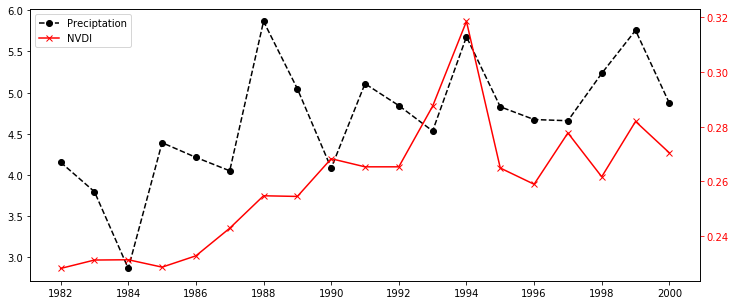

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

l1 = ax.plot(psahel_JJA.year[psahel_idx], psahel_JJA[psahel_idx], 
        marker='o', color='k', linestyle='--', label='Preciptation')
ax.yaxis.set_label_position('left')

ax_ = ax.twinx()
l2 = ax_.plot(vsahel_JJA.year[vsahel_idx], vsahel_JJA[vsahel_idx], 
         marker='x', color='red', label='NVDI')

ax_.yaxis.set_label_position('right')
ax_.tick_params(axis='y', colors='red')

ax_.xaxis.set_major_locator(mticker.MultipleLocator(2))  # adjust xaxis interval

# get legend for multiple overlay plots
plots = l1 + l2
labels = [l.get_label() for l in plots]
plt.legend(plots, labels, loc=2)

plt.show()

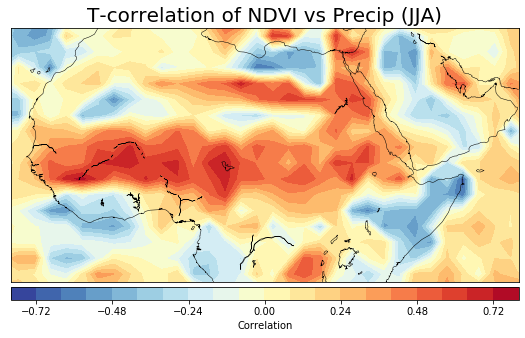

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

m = Basemap(
    lon_0=0, lat_0=0, # center of mat domain
    llcrnrlon=-20., llcrnrlat=-5., urcrnrlon=60., urcrnrlat=35., # projection region
        resolution='l', # boundary resolution (c, l, i, h, f)
        ax=ax
    )
    
coord = np.meshgrid(sahel_corr.lon, sahel_corr.lat)
m.drawcoastlines(linewidth=0.5, color='k') # draw coastline
m.drawlsmask(land_color='gray')

cs = m.contourf(coord[0], coord[1], sahel_corr,
            cmap=plt.cm.RdYlBu_r,  # reverse colormap order
            levels=20
            )

cb = m.colorbar(cs,"bottom", size="5%", pad='2%')
cb.set_label('Correlation')

ax.set_title('T-correlation of NDVI vs Precip (JJA)', fontsize=20)
plt.show()